# Generating Hand-written digits using GAN

In this notebook, we introduce the Generative Adversarial Networks and show how it can be applied to generate realistic pictures of handwritten digits.

This notebook is inpired by [this tutorial](https://medium.com/ai-society/gans-from-scratch-1-a-deep-introduction-with-code-in-pytorch-and-tensorflow-cb03cdcdba0f)

paper:
* [GAN](https://arxiv.org/abs/1406.2661)

In [1]:
!gpustat

phoebe  Fri May  4 11:52:47 2018
[0] GeForce GTX 1080 Ti | 54'C,  47 % | 10844 / 11172 MB | pbjo(7873M)
[1] GeForce GTX 1080 Ti | 67'C,  71 % | 10523 / 11172 MB | valv(10513M)
[2] GeForce GTX 1080 Ti | 51'C,  11 % |  3530 / 11172 MB | valv(2815M) valv(705M)
[3] GeForce GTX 1080 Ti | 75'C,  93 % |  1119 / 11172 MB | valv(1109M)
[4] GeForce GTX 1080 Ti | 74'C,  92 % |  1123 / 11172 MB | valv(1113M)
[5] GeForce GTX 1080 Ti | 67'C,  26 % | 11107 / 11172 MB | valv(11097M)
[6] GeForce GTX 1080 Ti | 63'C,  31 % | 11091 / 11172 MB | valv(11081M)
[7] GeForce GTX 1080 Ti | 67'C,  63 % | 10399 / 11172 MB | valv(10389M)


In [2]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from viz import updatable_display2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms, datasets

use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")

## The Data

For this experiment, we will use the traditional MNIST dataset.

In [3]:
def mnist_data():
    compose = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((.5, .5, .5), (.5, .5, .5))
        ])
    out_dir = 'MNIST'
    return datasets.MNIST(root=out_dir, train=True, transform=compose, download=True)
# Load data
data = mnist_data()
L = 28

## A Generative Model

In the GAN setup aims to build a generative model that models a distribution $p(x)$ of objects in an arbitrary space. In this case, the distribution $p(x)$ is the distribution of images corresponding to hand written digits in the space of the $28 \times 28$ pixels: in this space, there are $28 \times 28 \times 256 = 200704$ different combinations. Thus, this is a very difficult problem.

Furthermore, in a generative setup, we define a latent variable $z \sim p(z)$ which acts as a prior of $p(x)$ and is used to control the generation of samples $x$. Given $p(z)$, the goal is to find a mapping $G: z \rightarrow x$. Indeed, since $p(x)$ is a very complex distribution, we wish to sample $p(z)$ instead which is chosen as a simple distribution.

In this context, we approximate the *Generative* model $G$ using a neural networks with parameters $\theta_G$. we aim to find $\theta_G$ such as $\forall z \sim p(z), G(z,\theta_G) \in p(x)$

### The Generative Adversarial Networks

The GAN setup tackles this problem using a second network named the *Discrimator* Network. The Discrimator model $D$ takes samples $x$ as input and tries to assess if the sample was real ($x \sim p(x)$ : the sample was taken from the dataset) or fake ($x = G(z), z \sim p(z)$: the sample was generated). Thus, $D$ outputs a probability for an input $x$ to be sampled from $p(x)$ rather than $p_G$.

The two networks $D$ and $G$ are simulatenously trained such as $D$ tries to differentiate real samples from generated samples and such as $G$ successfully fool the discrimator $D$. In other words, $D$ and $G$ play the following two-player minimax game with value function $V (G, D)$:

$\underset{min}{G}\underset{max}{D} = \mathop{\mathbb{E}}_{x \sim p_{data}(x)} [\log D(x)] +  \mathop{\mathbb{E}}_{z \sim p_z(z)}[\log(1-D(G(z)))]$


### Implementation:

* The Discriminator Network is implemented as a simple Multi-layer perceptron that takes an image $x$ as input and estimates the probability for this sample to be real: $D : x \rightarrow MLP(x) \in [0,1]$
* The Generator Network is implemented as a simple Multi-layer perceptron that takes an k-dimensional noise value $z$ and generate a sample $x$: $G : z \rightarrow MLP(z) \in [0,1]^{N_{pixels}}$

### Multi-Layer Perceptron

In [4]:
class MLP(nn.Module):
    """
    Multi Layer Perceptron
    """
    def __init__(self, num_hidden_features,dropout=0,activation=nn.Tanh,last_activation=nn.Tanh):
        super(MLP, self).__init__()
        layers = []
        for i in range(len(num_hidden_features) - 2):
            in_features = num_hidden_features[i]
            out_features = num_hidden_features[i+1]
            layers += [ nn.Linear(in_features=in_features, out_features=out_features), #nn.BatchNorm1d(out_features),
                       nn.Dropout(dropout), activation()]
        in_features = num_hidden_features[i]
        out_features = num_hidden_features[i+1]
        layers += [ nn.Linear(in_features=num_hidden_features[-2], out_features=num_hidden_features[-1]), #nn.BatchNorm1d(num_hidden_features[-1]),
                   last_activation()]
        self.mlp = nn.Sequential(*layers)
    def forward(self, x):
        return self.mlp(x)

### Some Utilities

In [5]:
def images_to_vectors(images):
    """
    flatten batch of images
    """
    return images.view(images.size(0), L**2)

def vectors_to_images(vectors):
    """
    reconstruct batch of images from batch of flattened images
    """
    return vectors.view(vectors.size(0), 1, L, L)

def noise(size,noise_dim):
    '''
    Generates a 1-d vector of gaussian sampled random values
    '''
    n = torch.randn(size, noise_dim)
    return n.to(device)

def ones_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = torch.ones(size, 1)
    return data.to(device)

def zeros_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = torch.zeros(size, 1)
    return data.to(device)


## Training

Training parameters

In [26]:
batch_size = 128
m = int(np.sqrt(batch_size))-1
lr = 2e-4
dropout = 0.3
noise_dim = 100
num_layers = 2
n_out = L**2

num_test_samples = m**2
test_noise = noise(num_test_samples,noise_dim)

# models
try:
    del generator
except:
    0
try:
    del discriminator
except:
    0

# intialize the models
generator = MLP([noise_dim,256,512,1024,n_out],dropout=0,activation= lambda : nn.LeakyReLU(0.2),last_activation=nn.Tanh).to(device)
discriminator = MLP([n_out,1024,512,256,1],dropout=dropout,activation= lambda : nn.LeakyReLU(0.3),last_activation=nn.Sigmoid).to(device)

# otpimizers
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr)
g_optimizer = optim.Adam(generator.parameters(), lr=lr)
loss = nn.BCELoss()

# data loader
data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)

# Create logger instance
dis = updatable_display2(['train'],["epoch","d_error","g_error"])
# Total number of epochs to train
num_epochs = 200
global_step=0
epoch =0
g_error = 0

#### Training $D$

In [27]:
def train_discriminator(optimizer, real_data, fake_data):
    """
    Train the discriminator to dicriminate real data from fake data
    """
    N = real_data.size(0)
    # Reset gradients
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data)
    # Calculate error and backpropagate
    error_real = loss(prediction_real, ones_target(N) )
    error_real.backward()

    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, zeros_target(N))
    error_fake.backward()
    
    # 1.3 Update weights with gradients
    optimizer.step()
    
    # Return error and predictions for real and fake inputs
    return error_real + error_fake

#### Training $G$

In [28]:
def train_generator(optimizer, fake_data):
    """
    train the generator to fool the discriminator
    """
    N = fake_data.size(0)
    # Reset gradients
    optimizer.zero_grad()
    # Sample noise and generate fake data
    prediction = discriminator(fake_data)
    # Calculate error and backpropagate
    error = loss(prediction, ones_target(N))
    error.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error

#### Full Training

We train the discriminator $D$ more steps than we train $G$

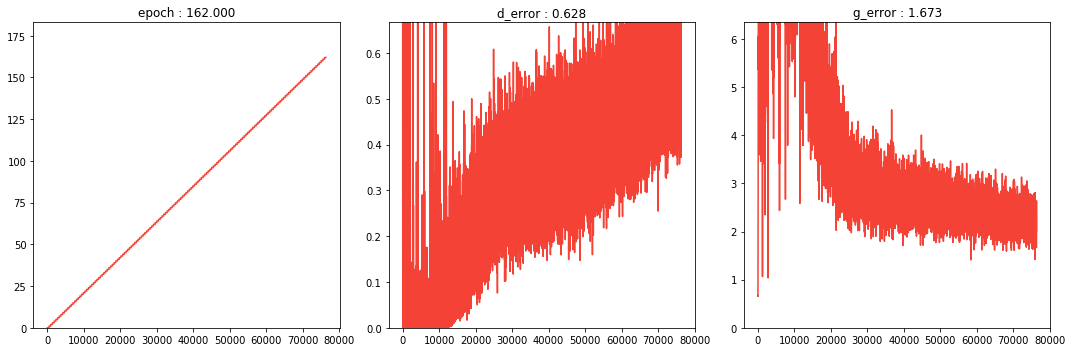

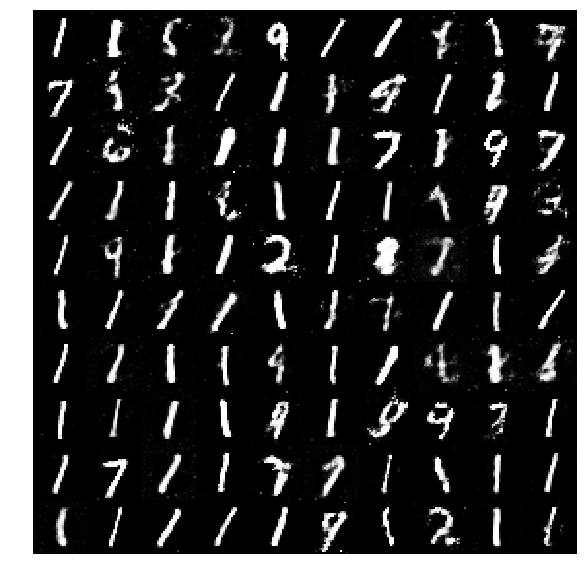

In [29]:
gen_steps = 1
gen_train_freq = 5
try:
    while True:
        for n_batch, (real_batch,_) in enumerate(data_loader):
            N = real_batch.size(0)
            # 1. Train Discriminator
            real_data = images_to_vectors(real_batch).to(device)
            # Generate fake data and detach 
            # (so gradients are not calculated for generator)
            noise_tensor = noise(N,noise_dim)
            with torch.no_grad():
                fake_data = generator(noise_tensor).detach()
            # Train D
            d_error = train_discriminator(d_optimizer, real_data, fake_data)
            
            # 2. Train Generator every 'gen_train_freq' steps
            if global_step % gen_train_freq == 0:
                for _ in range(gen_steps):
                    # Generate fake data
                    fake_data = generator(noise(N,noise_dim))
                    # Train G
                    g_error = train_generator(g_optimizer, fake_data)
                    g_error = g_error.item()
                    
            # Log batch error and delete tensors
            dis.update(global_step,'train',{"epoch":epoch,"d_error":d_error.item(),"g_error":g_error} )
            global_step+=1
            del fake_data
            del real_data
            del noise_tensor
            
            # Display Progress every few batches
            if global_step % 50 == 0:
                test_images = vectors_to_images(generator(test_noise))
                test_images = test_images.data
                L = 28
                canvas = np.zeros((L*m,L*m))
                q = 0
                for i in range(m):
                    for j in range(m):
                        canvas[i*L:(i+1)*L,j*L:(j+1)*L] = test_images[q]
                        q+=1
                dis.display(scale=True)
                plt.figure(figsize=(10,10))
                plt.imshow(canvas,cmap='gray')
                plt.axis("off")
                if epoch % 50 == 0:
                    plt.savefig("GAN-MNIST-Epoch="+str(epoch)+".png")
                plt.show()
        epoch+=1
except:
    test_images = vectors_to_images(generator(test_noise))
    test_images = test_images.data
    L = 28
    canvas = np.zeros((L*m,L*m))
    q = 0
    for i in range(m):
        for j in range(m):
            canvas[i*L:(i+1)*L,j*L:(j+1)*L] = test_images[q]
            q+=1
    dis.display(scale=True)
    plt.figure(figsize=(10,10))
    plt.imshow(canvas,cmap='gray')
    plt.axis("off")
    plt.savefig("GAN-MNIST.png")
    plt.show()

### Conclusion

In a few lines, we implemented a GAN to generate realistic handwritten digits which demonstrates the effectiveness of this model. However, tunining the hyperparameters of this model was a difficult task (which can't assess by reading through this notebook). Modifying slightly this architecture resulted in a model that failed to learn. While GAN models are powerful generative models, they are often difficult to train. This simple model is enough for modeling handwritten digits but may be impractible to use in the context of fiber network modeling. In the next notebooks, we will experiment different improvements brought to the GAN model: a different loss functions and bounded weights with the Wassertein GAN and more powerful functions approximators with the DC-GAN.